In [1]:
library(tidyverse)
library(cowplot)
library(arrow)

── Attaching core tidyverse packages ─────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




# Phenotype summary

In [2]:
anon_random_phenotypes_df <- read_parquet("data/anon_random_phenotypes.parquet")
anon_random_phenotypes_preds_df <- read_parquet("data/anon_random_phenotypes_pred.parquet")

phenotype_r2_df <- anon_random_phenotypes_df %>%
    mutate(person_id = row_number()) %>%
    pivot_longer(-person_id, names_to = "phenotype_id", values_to = "phenotype_value") %>%
    inner_join(
        anon_random_phenotypes_preds_df %>%
            mutate(person_id = row_number()) %>%
            pivot_longer(-person_id, names_to = "phenotype_id", values_to = "phenotype_pred"),
        by = c("person_id", "phenotype_id")
    ) %>%
    group_by(phenotype_id) %>%
    summarize(
        phenotype_r = cor(phenotype_value, phenotype_pred),
        phenotype_r2 = phenotype_r^2
    ) %>%
    mutate(
        phenotype_id = phenotype_id %>% str_extract("[0-9]+$") %>% as.integer
    )

phenotype_r2_df %>% head(2)

phenotype_id,phenotype_r,phenotype_r2
<int>,<dbl>,<dbl>
1,1,1
10,1,1


# GWAS summary

In [3]:
full_gwas_df <- read_parquet("data/full_gwas.parquet")

full_gwas_df %>% head(2)

phenotype_id,variant_id,P_true,P_predicted
<int>,<chr>,<dbl>,<dbl>
1,1:760912,0.1454000,0.1736820
1,1:853954,0.0505077,0.0477667


In [4]:
full_gwas_df %>%
    summarize(across(starts_with("P_"), list("min" = min, "max" = max)))

P_true_min,P_true_max,P_predicted_min,P_predicted_max
<dbl>,<dbl>,<dbl>,<dbl>
8.624e-189,1,7.84568e-189,1


In [5]:
gwas_summary_df <- full_gwas_df %>%
    mutate(across(c(P_true, P_predicted), ~-log10(.x), .names = "{.col}_nlog10")) %>%
    group_by(phenotype_id) %>%
    summarize(
        gwas_r = cor(P_true_nlog10, P_predicted_nlog10),
        gwas_r2 = gwas_r^2,
    )

# Combine results

In [6]:
summary_df <- gwas_summary_df %>%
    inner_join(phenotype_r2_df, by = "phenotype_id")

summary_df %>%
    write_parquet("data/phenotype_vs_gwas_r2.parquet")

summary_df %>% head(2)

phenotype_id,gwas_r,gwas_r2,phenotype_r,phenotype_r2
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.98129181,0.962933625,1.0000000,1.0000000
2,0.09953765,0.009907744,0.6667765,0.4445908


# Plot results

`geom_smooth()` using formula = 'y ~ x'


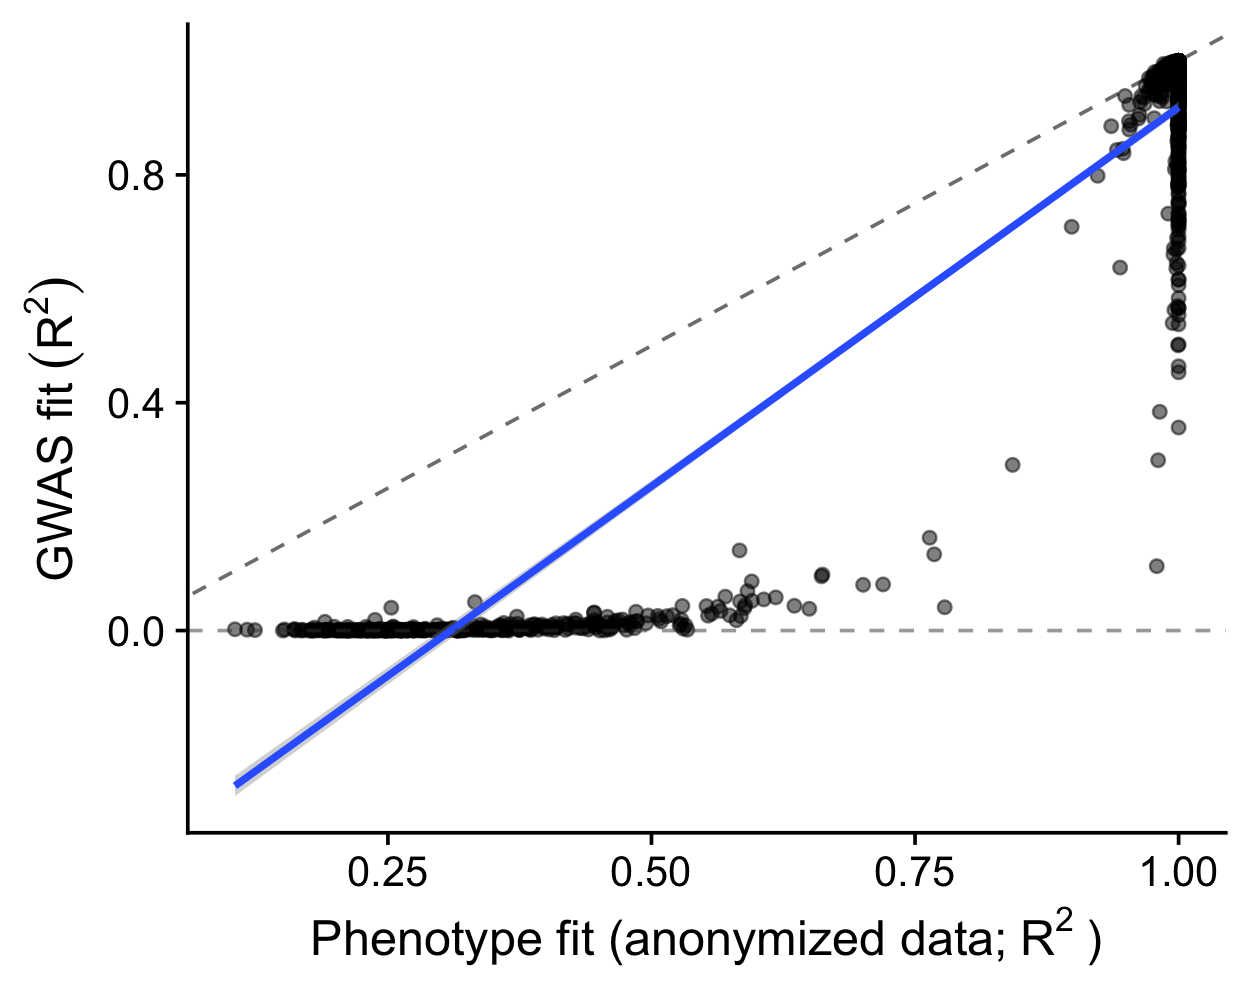

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

summary_df %>%
    ggplot(aes(x = phenotype_r2, y = gwas_r2)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    geom_hline(yintercept = 0., linetype = "dashed", color = "grey25", alpha = 0.5) +
    # geom_hline(yintercept = 0.5, linetype = "dashed", color = "red", alpha = 0.5) +
    # geom_vline(xintercept = 0.8, linetype = "dashed", color = "red", alpha = 0.5) +
    # annotate("rect", xmin = 0.8, xmax = 1, ymin = 0.5, ymax = 1, alpha = 0.1, fill = "red") +
    theme_cowplot() +
    xlab(expression("Phenotype fit (anonymized data;"~R^2~")")) +
    ylab(expression("GWAS fit"~(R^2)))

`geom_smooth()` using formula = 'y ~ x'


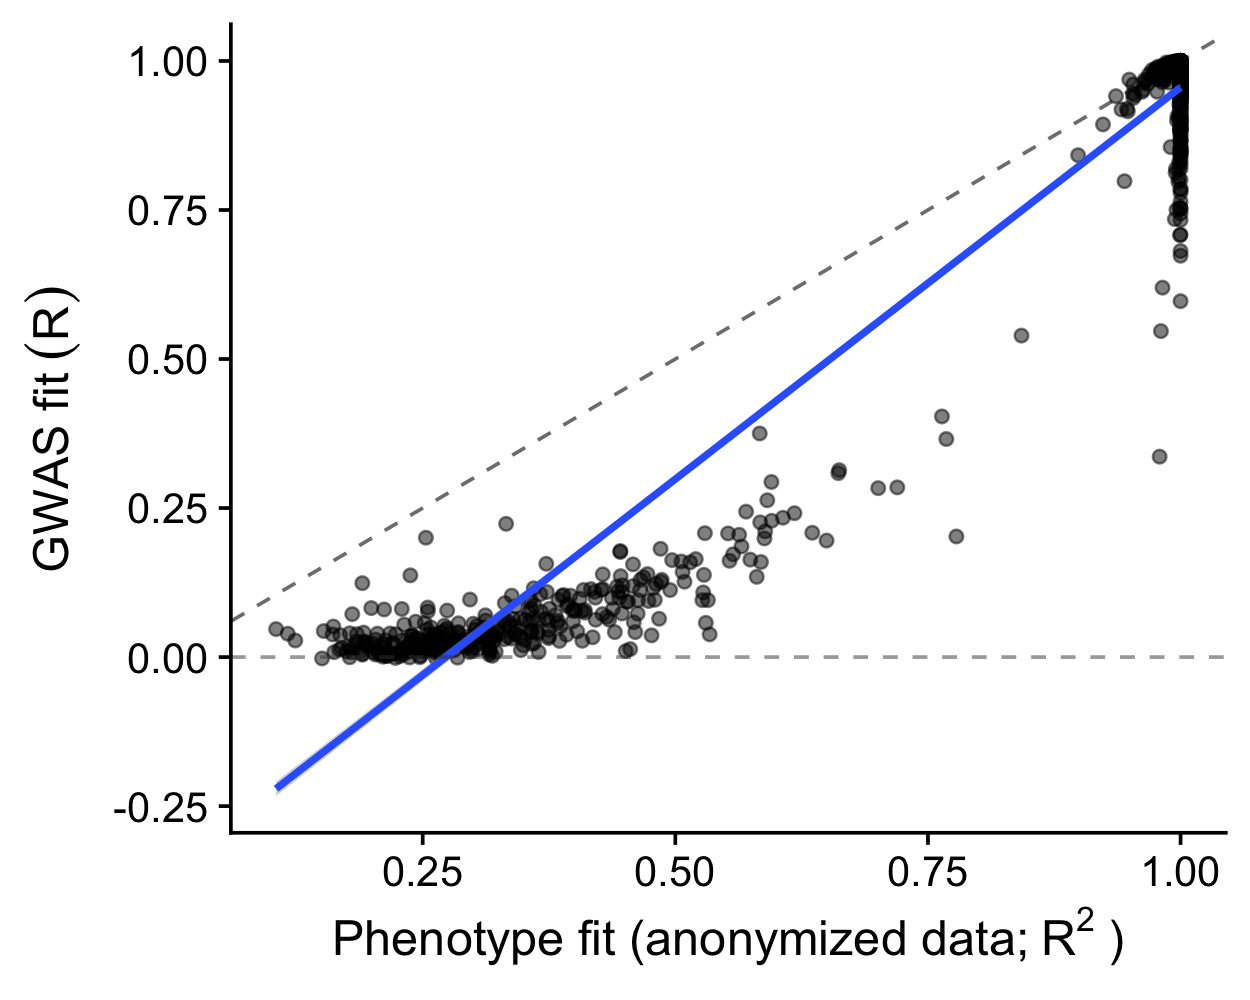

In [8]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

summary_df %>%
    ggplot(aes(x = phenotype_r2, y = gwas_r)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    geom_hline(yintercept = 0., linetype = "dashed", color = "grey25", alpha = 0.5) +
    # geom_hline(yintercept = 0.5, linetype = "dashed", color = "red", alpha = 0.5) +
    # geom_vline(xintercept = 0.8, linetype = "dashed", color = "red", alpha = 0.5) +
    # annotate("rect", xmin = 0.8, xmax = 1, ymin = 0.5, ymax = 1, alpha = 0.1, fill = "red") +
    theme_cowplot() +
    xlab(expression("Phenotype fit (anonymized data;"~R^2~")")) +
    ylab(expression("GWAS fit"~(R)))

`geom_smooth()` using formula = 'y ~ x'


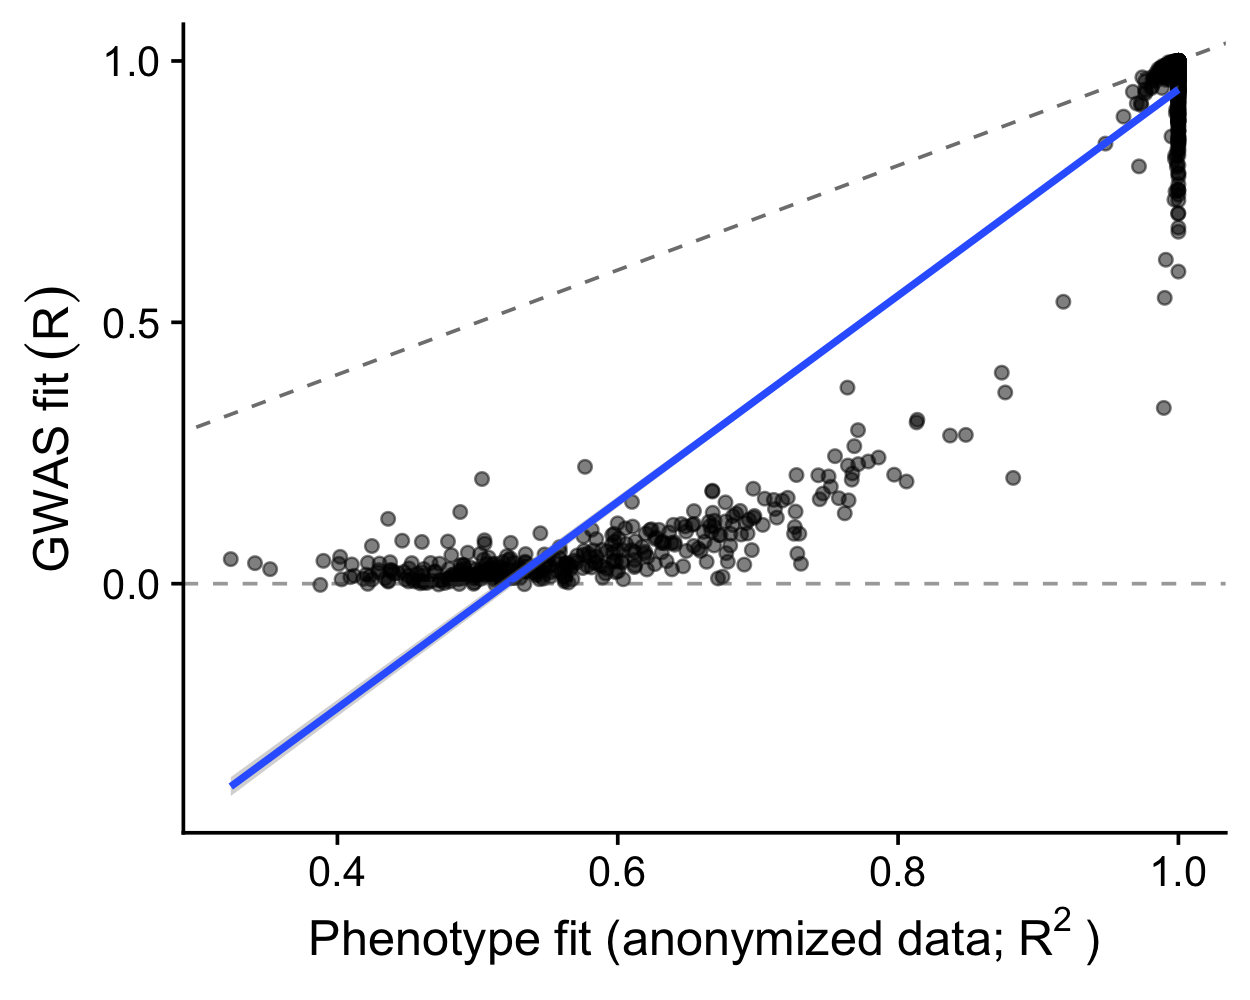

In [9]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

summary_df %>%
    ggplot(aes(x = phenotype_r, y = gwas_r)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    geom_hline(yintercept = 0., linetype = "dashed", color = "grey25", alpha = 0.5) +
    # geom_hline(yintercept = 0.5, linetype = "dashed", color = "red", alpha = 0.5) +
    # geom_vline(xintercept = 0.8, linetype = "dashed", color = "red", alpha = 0.5) +
    # annotate("rect", xmin = 0.8, xmax = 1, ymin = 0.5, ymax = 1, alpha = 0.1, fill = "red") +
    theme_cowplot() +
    xlab(expression("Phenotype fit (anonymized data;"~R^2~")")) +
    ylab(expression("GWAS fit"~(R)))

`geom_smooth()` using formula = 'y ~ x'


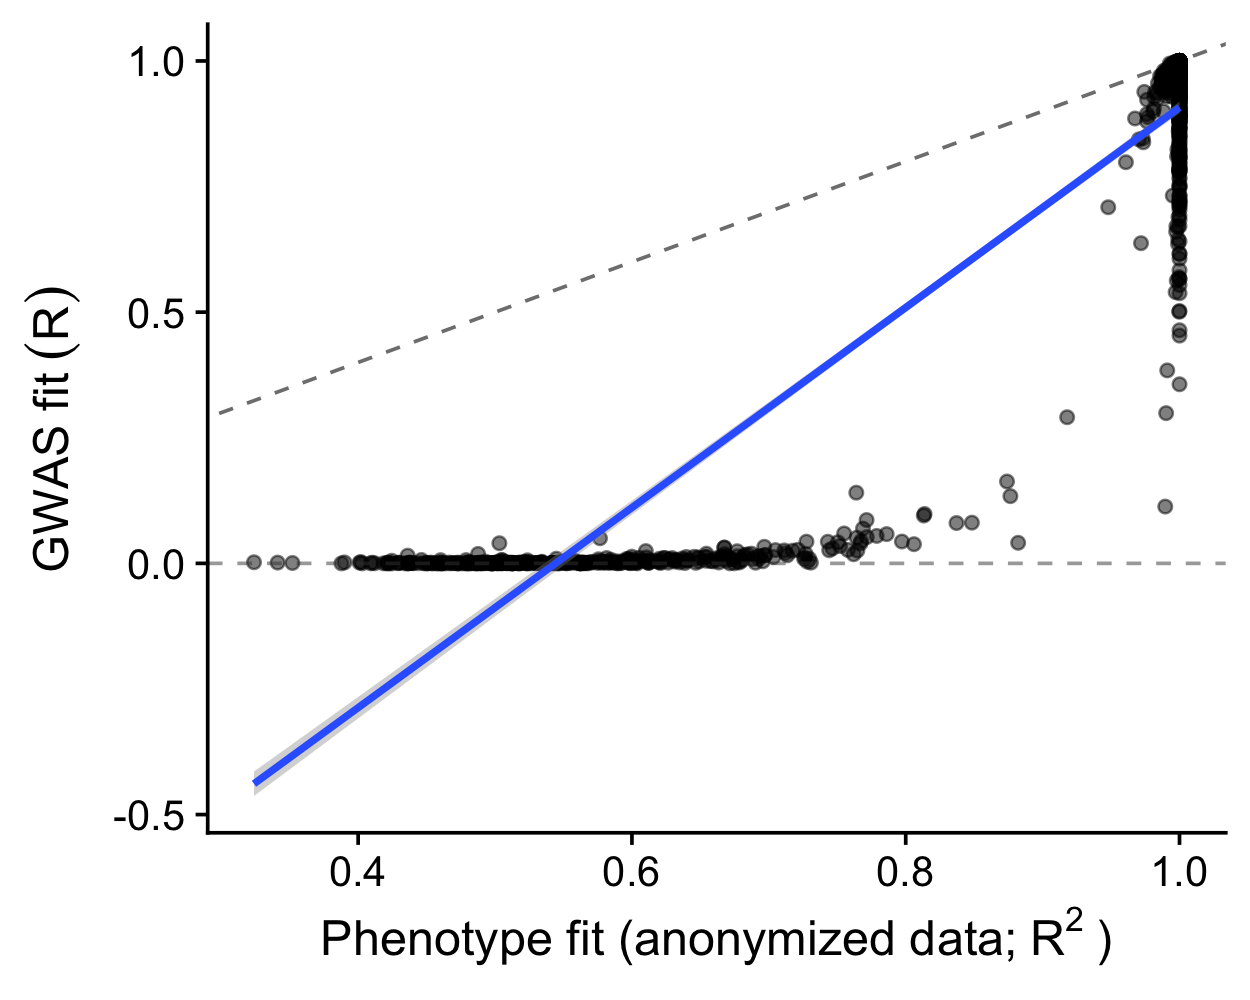

In [10]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

summary_df %>%
    ggplot(aes(x = phenotype_r, y = gwas_r2)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    geom_hline(yintercept = 0., linetype = "dashed", color = "grey25", alpha = 0.5) +
    # geom_hline(yintercept = 0.5, linetype = "dashed", color = "red", alpha = 0.5) +
    # geom_vline(xintercept = 0.8, linetype = "dashed", color = "red", alpha = 0.5) +
    # annotate("rect", xmin = 0.8, xmax = 1, ymin = 0.5, ymax = 1, alpha = 0.1, fill = "red") +
    theme_cowplot() +
    xlab(expression("Phenotype fit (anonymized data;"~R^2~")")) +
    ylab(expression("GWAS fit"~(R)))

In [11]:
bind_rows(
    summary_df %>%
        lm(gwas_r2 ~ phenotype_r2, data = .) %>%
        broom::glance() %>%
        mutate(gwas = "r2", phenotype = "r2"),
    summary_df %>%
        lm(gwas_r2 ~ phenotype_r, data = .) %>%
        broom::glance() %>%
        mutate(gwas = "r2", phenotype = "r"),
    summary_df %>%
        lm(gwas_r ~ phenotype_r2, data = .) %>%
        broom::glance() %>%
        mutate(gwas = "r", phenotype = "r2"),
    summary_df %>%
        lm(gwas_r ~ phenotype_r, data = .) %>%
        broom::glance() %>%
        mutate(gwas = "r", phenotype = "r"),
)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs,gwas,phenotype
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
0.9197034,0.9196230,0.12756412,11430.922,0,1,641.1986,-1276.3972,-1261.6739,16.240059,998,1000,r2,r2
0.8910307,0.8909215,0.14860451,8160.546,0,1,488.5292,-971.0585,-956.3352,22.039135,998,1000,r2,r
0.9597684,0.9597281,0.08729587,23808.401,0,1,1020.5145,-2035.0291,-2020.3058,7.605329,998,1000,r,r2
0.9358568,0.9357925,0.11022640,14560.936,0,1,787.2813,-1568.5625,-1553.8393,12.125561,998,1000,r,r
